In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
#from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
#from yellowbrick.model_selection import FeatureImportances
#import shap
import joblib
%matplotlib inline


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

pd.set_option('display.float_format', '{:.6f}'.format)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

#### Attributes Information

1. id :	Unique ID for the customer

2. Gender	: Gender of the customer

3. Age :	Age of the customer

4. Driving_License	0 : Customer does not have DL, 1 : Customer already has DL

5. Region_Code :	Unique code for the region of the customer

6. Previously_Insured	: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

7. Vehicle_Age :	Age of the Vehicle

8. Vehicle_Damage	 :1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

9. Annual_Premium	: The amount customer needs to pay as premium in the year

10. PolicySalesChannel :	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

11. Vintage :	Number of Days, Customer has been associated with the company

12. Response :	1 : Customer is interested, 0 : Customer is not interested

## feature wise preporcessing strategy

- id: drop it
- drop duplicates
- gender, vehicle_damage: binary encode to 0 or 1
- region code and policy sales channel: Frequency encoding
- Vehicle Age: One hot encoding
- transform annual premium to reduce skewness and to remove outliers cap it

In [2]:
df = pd.read_csv(r"C:\Users\user\Desktop\BIA Insurance Prediction Project\data\data.csv")

# checking first few samples
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.000000,0,> 2 Years,Yes,40454.000000,26.000000,217,1
1,2,Male,76,1,3.000000,0,1-2 Year,No,33536.000000,26.000000,183,0
2,3,Male,47,1,28.000000,0,> 2 Years,Yes,38294.000000,26.000000,27,1
3,4,Male,21,1,11.000000,1,< 1 Year,No,28619.000000,152.000000,203,0
4,5,Female,29,1,41.000000,1,< 1 Year,No,27496.000000,152.000000,39,0


In [3]:
#dropping ID as it isnt relevant to the customer's response
df.drop('id', axis =1, inplace = True)

In [4]:
#dropping duplicate values from the dataset
df = df.drop_duplicates(keep='first')

In [5]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.000000,0,> 2 Years,Yes,40454.000000,26.000000,217,1
1,Male,76,1,3.000000,0,1-2 Year,No,33536.000000,26.000000,183,0
2,Male,47,1,28.000000,0,> 2 Years,Yes,38294.000000,26.000000,27,1
3,Male,21,1,11.000000,1,< 1 Year,No,28619.000000,152.000000,203,0
4,Female,29,1,41.000000,1,< 1 Year,No,27496.000000,152.000000,39,0


In [6]:
numeric_features = ['Age','Annual_Premium', 'Vintage'] # numerical features
cat_encoded_feature = ['Policy_Sales_Channel','Region_Code'] # categorical features that were encoded numerically
cat_label_features = ['Vehicle_Age', 'Gender' ,'Vehicle_Damage','Driving_License','Previously_Insured'] # categorical features

- for cat_label_features, we can binary encoding.
- for cat_encoded_features we will use frequency encoding

- We'll be fitting for X_train and transform accordingly for X_test

In [7]:
df1 = df.copy()

In [8]:
le = LabelEncoder()
for col in ['Gender', 'Vehicle_Damage']:
    df1[col] = le.fit_transform(df1[col])

In [9]:
vehicle_age_dummies = pd.get_dummies(
    df1['Vehicle_Age'],
    prefix='Vehicle_Age',
    drop_first=True,
    dtype=int
)

df1 = pd.concat([df1.drop(columns=['Vehicle_Age']), vehicle_age_dummies], axis=1)


In [10]:
df1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,44,1,28.000000,0,1,40454.000000,26.000000,217,1,0,1
1,1,76,1,3.000000,0,0,33536.000000,26.000000,183,0,0,0
2,1,47,1,28.000000,0,1,38294.000000,26.000000,27,1,0,1
3,1,21,1,11.000000,1,0,28619.000000,152.000000,203,0,1,0
4,0,29,1,41.000000,1,0,27496.000000,152.000000,39,0,1,0


In [11]:
df_train, df_test = train_test_split(
    df1,
    test_size=0.2,
    random_state=21,
    stratify=df1['Response']   # strongly recommended for classification
)

In [12]:
# freqency encoding

columns_to_change = ['Policy_Sales_Channel', 'Region_Code']

for col in columns_to_change:
    freq = df_train[col].value_counts(normalize=True)
    df_train[col] = df_train[col].map(freq)

    freq_test = df_train[col].value_counts(normalize=True)
    df_train[col] = df_train[col].map(freq_test)

In [13]:
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
235830,1,56,1,0.018226,0,1,33371.000000,0.193963,46,0,0,1
59581,0,74,1,0.279714,1,0,50259.000000,0.193963,159,0,0,0
230275,1,46,1,0.088761,0,1,33946.000000,0.193963,214,0,0,0
145514,1,21,1,0.014754,0,1,22494.000000,0.056914,98,0,1,0
123031,0,36,1,0.279714,0,1,37913.000000,0.193963,258,0,0,0


In [14]:
# functions

def value_count_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value count
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    fig, ax = plt.subplots(figsize=(18,10))
    sns.histplot(df[feature],bins=the_bins,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=value_count_norm_cal(df,feature).index,y=value_count_norm_cal(df,feature).values[:,0])
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Count')
    plt.xticks(rotation=45,ha='right')
    plt.title('{} count'.format(feature))
    return plt.show()

def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    fig, ax = plt.subplots(figsize=(2,8))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution(Boxplot)'.format(feature))
    return plt.show()


def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Annual_Premium' | 'Vintage':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
            print('*'*50)
            print('kurtosis:\n{}'.format(df[feature].kurtosis()))
            
        
        case 'Region_Code' | 'Policy_Sales_Channel':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            
        case _:

            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_count_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))
           
    print('*'*50)
    print()

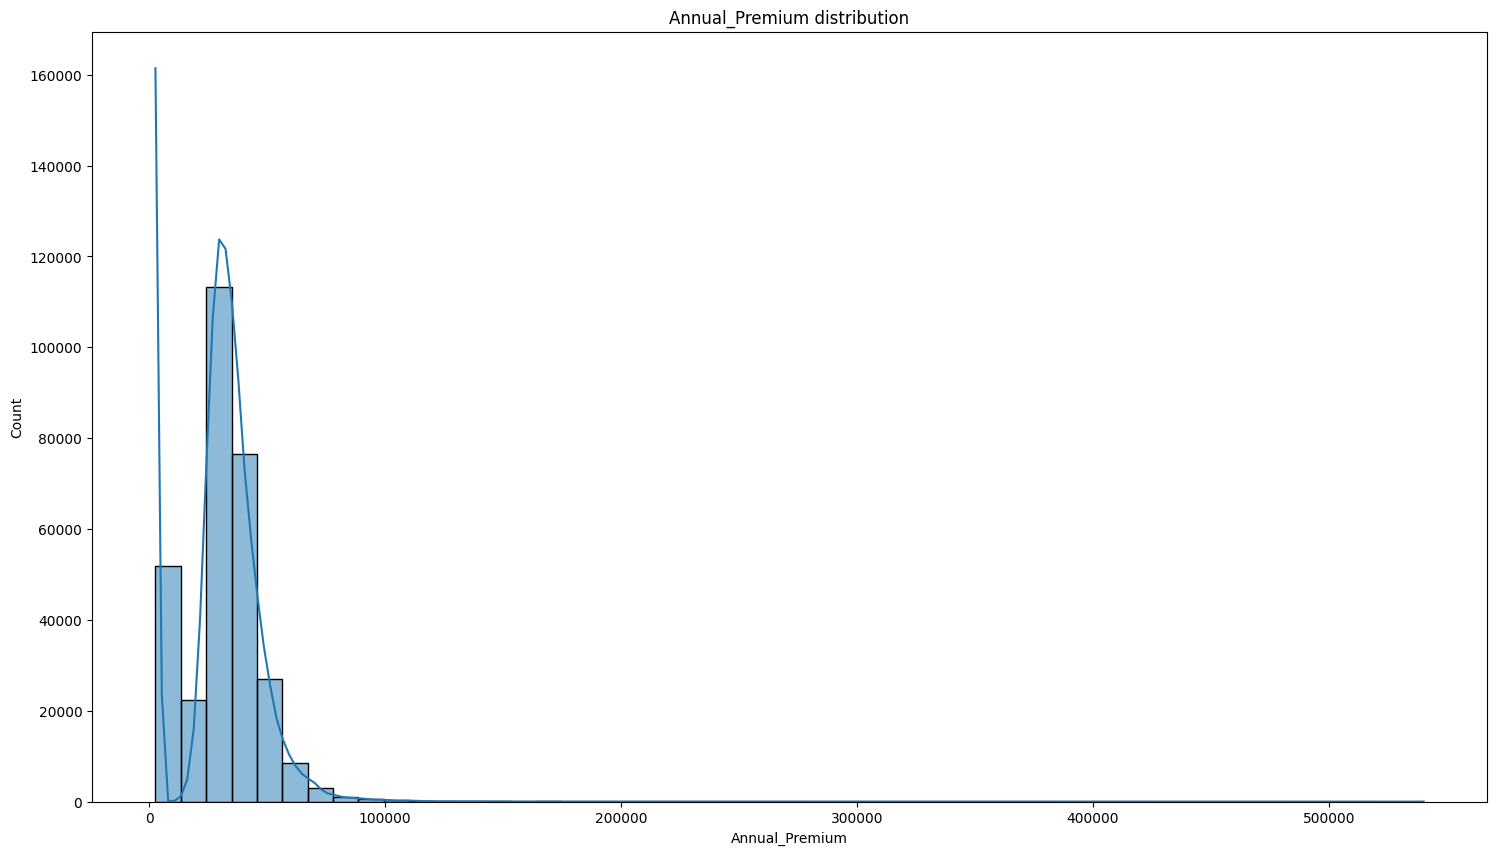

In [15]:
create_hist_plot(df_train, 'Annual_Premium')

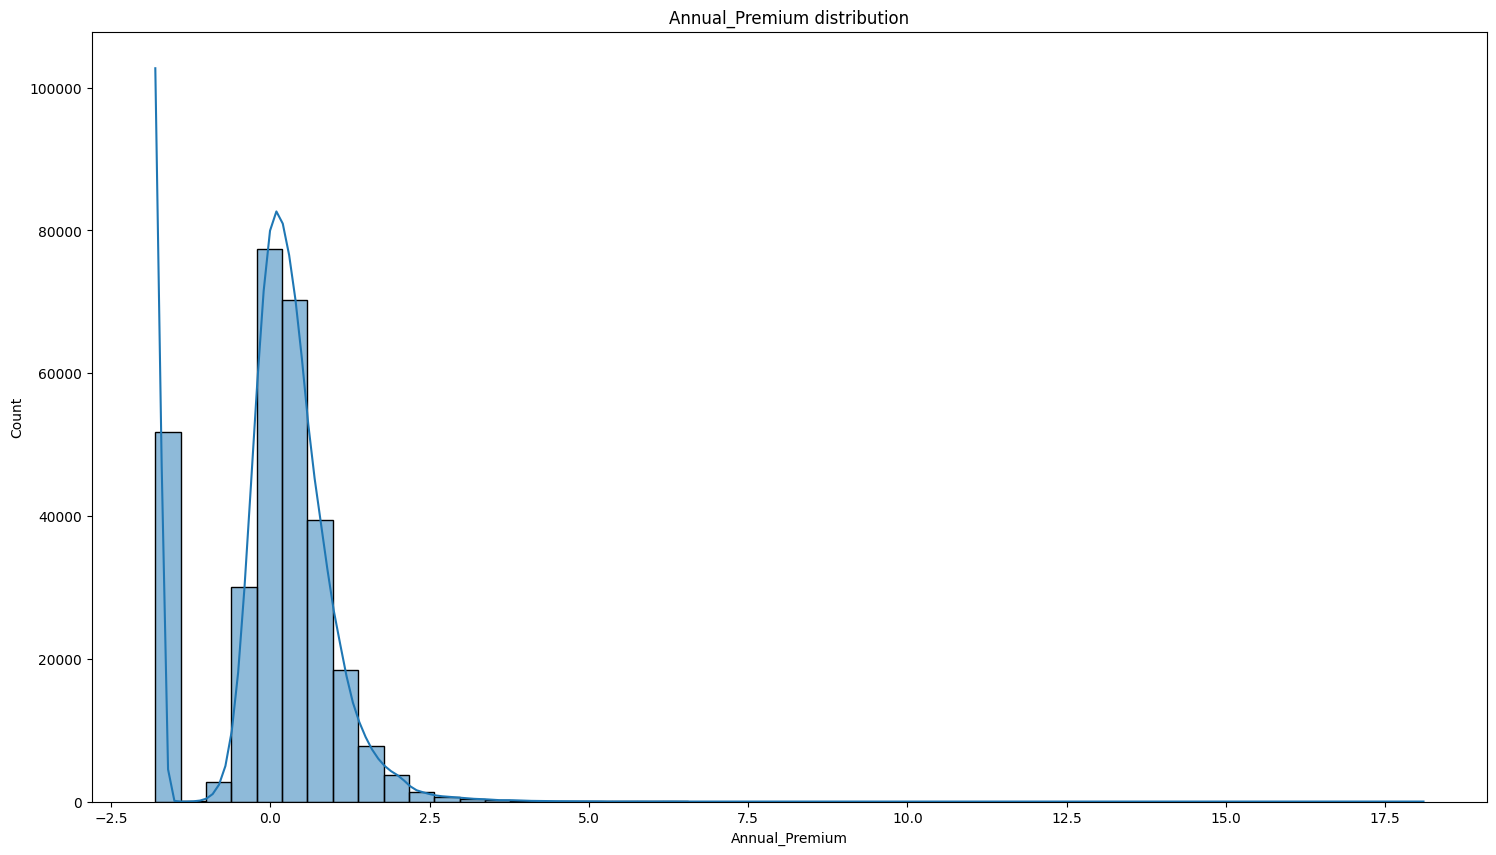

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
235830,1,56,1,0.018226,0,1,0.231968,0.193963,46,0,0,1
59581,0,74,1,0.279714,1,0,1.111589,0.193963,159,0,0,0
230275,1,46,1,0.088761,0,1,0.263389,0.193963,214,0,0,0
145514,1,21,1,0.014754,0,1,-0.389599,0.056914,98,0,1,0
123031,0,36,1,0.279714,0,1,0.476967,0.193963,258,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
278488,1,53,1,0.012364,0,1,-1.805716,0.002321,42,0,0,0
219297,1,23,1,0.003404,0,1,0.193712,0.353728,76,0,1,0
75461,0,30,1,0.026901,1,0,-0.077426,0.353728,268,0,1,0
321757,1,39,1,0.024183,0,1,-0.262000,0.209346,268,1,0,0


In [16]:
# handle skewdness using box cox method
df_train1 = df_train.copy()
# 1. Define columns
def skew_correction(df, function):
    df = df.copy()
    skewed_cols = ['Annual_Premium']

    # 2. Apply cube root transformation directly
    
    df[skewed_cols] = function(df[skewed_cols])

    for col in skewed_cols:
        create_hist_plot(df, col)
    return df

# box-cox transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

skew_correction(df_train1, pt.fit_transform)

In [17]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(df_train1[['Annual_Premium']])

PowerTransformer()

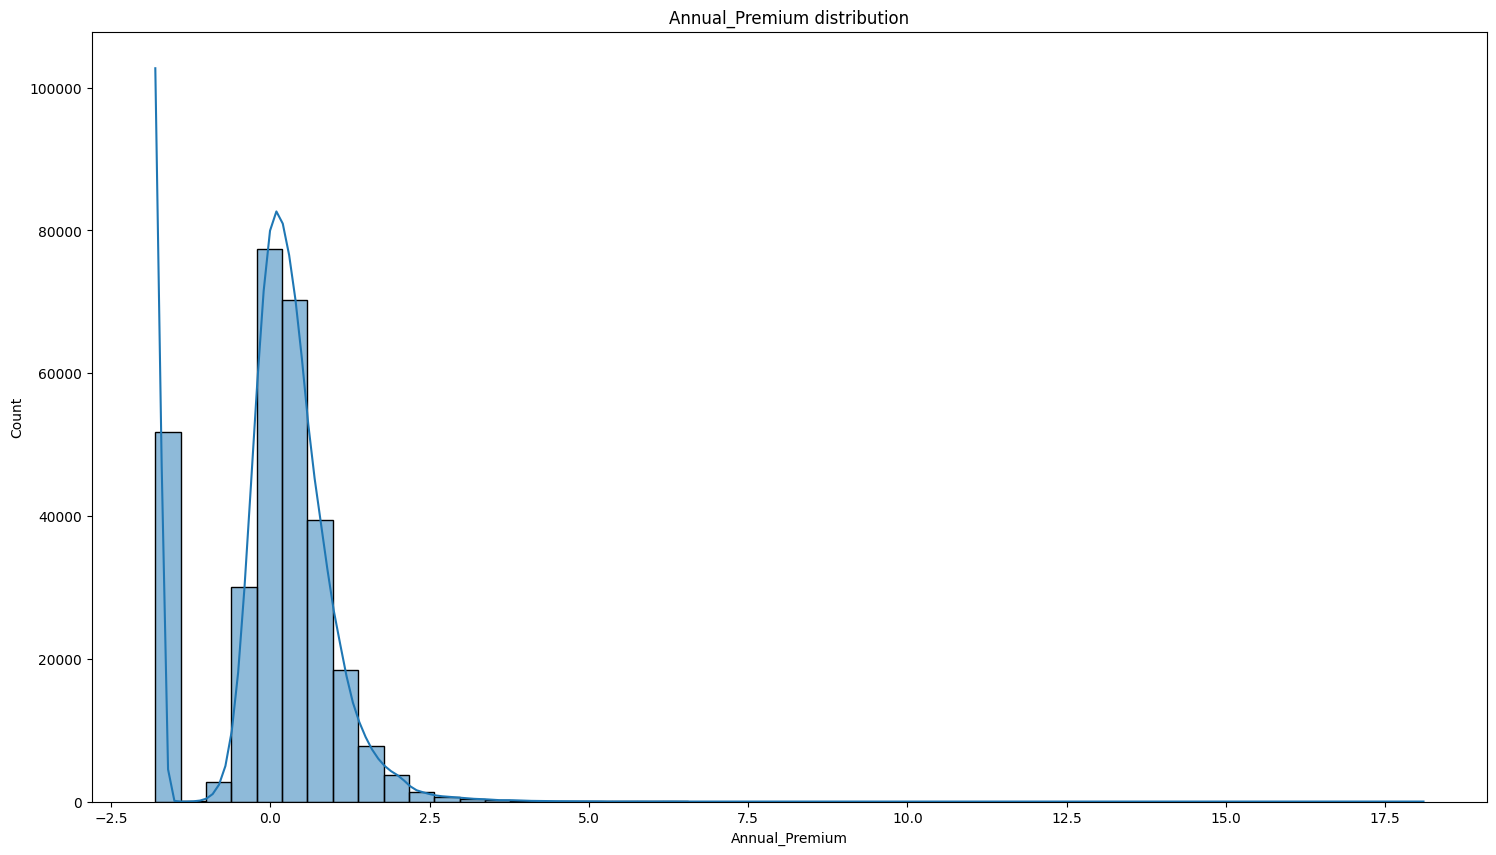

In [18]:
df_train1 = skew_correction(df_train1, pt.fit_transform)

In [19]:
import joblib
joblib.dump(pt, 'power_transformer.pkl')


['power_transformer.pkl']

In [21]:
gen_info_feat(df_train1,'Annual_Premium')

Description:
count   304672.000000
mean        -0.000000
std          1.000002
min         -1.805716
25%         -0.274988
50%          0.139742
75%          0.556732
max         18.101140
Name: Annual_Premium, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
0.07849958593068705
**************************************************
kurtosis:
6.014689874019897
**************************************************



In [22]:
gen_info_feat(df_test1,'Annual_Premium')

Description:
count   76168.000000
mean       -0.000652
std         1.000569
min        -1.805716
25%        -0.274179
50%         0.134283
75%         0.553781
max        18.101140
Name: Annual_Premium, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
0.17498063668858077
**************************************************
kurtosis:
7.149735699810855
**************************************************



In [23]:
# remove outliers from annual premium

# Removes rows containing outliers using the IQR method.
# For each selected numerical feature, values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are treated as outliers.
# Any row with at least one outlier is dropped to produce a cleaner dataset.

def remove_outliers_iqr(df):
    # Create a copy to prevent SettingWithCopy warnings
    df = df.copy()
    
    # Define features to check
    outlier_ft = ['Annual_Premium']

    # Calculate IQR bounds
    Q1 = df[outlier_ft].quantile(0.25)
    Q3 = df[outlier_ft].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify rows that have at least one outlier in the specified columns
    is_outlier = ((df[outlier_ft] < lower_bound) | (df[outlier_ft] > upper_bound)).any(axis=1)
    
    # Filter and return the cleaned dataframe
    return df[~is_outlier]

df_train1 = remove_outliers_iqr(df_train1)
df_test1 = remove_outliers_iqr(df_test1)


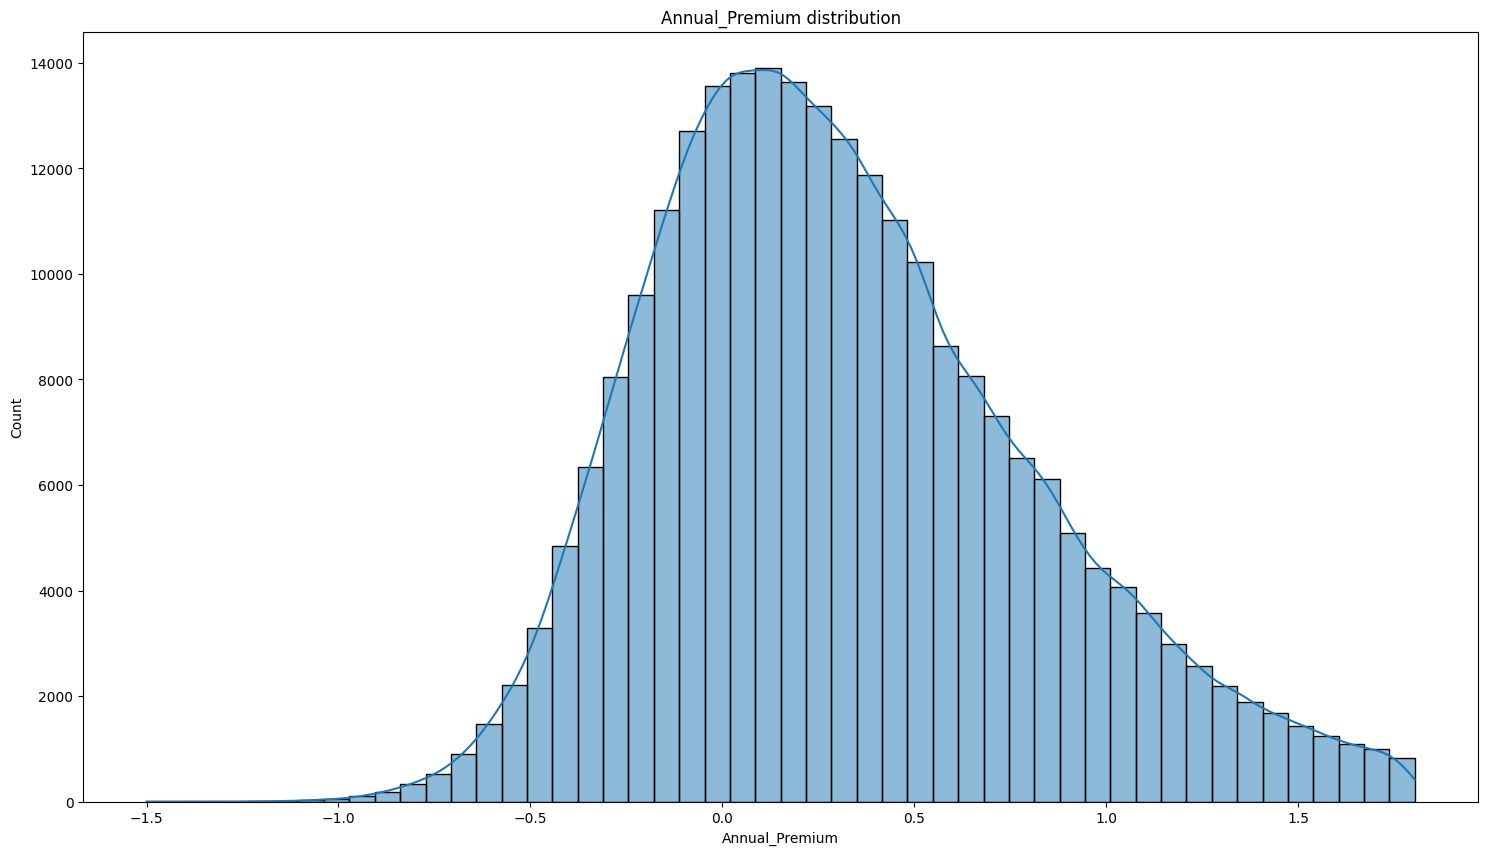

In [24]:
create_hist_plot(df_train1, 'Annual_Premium')

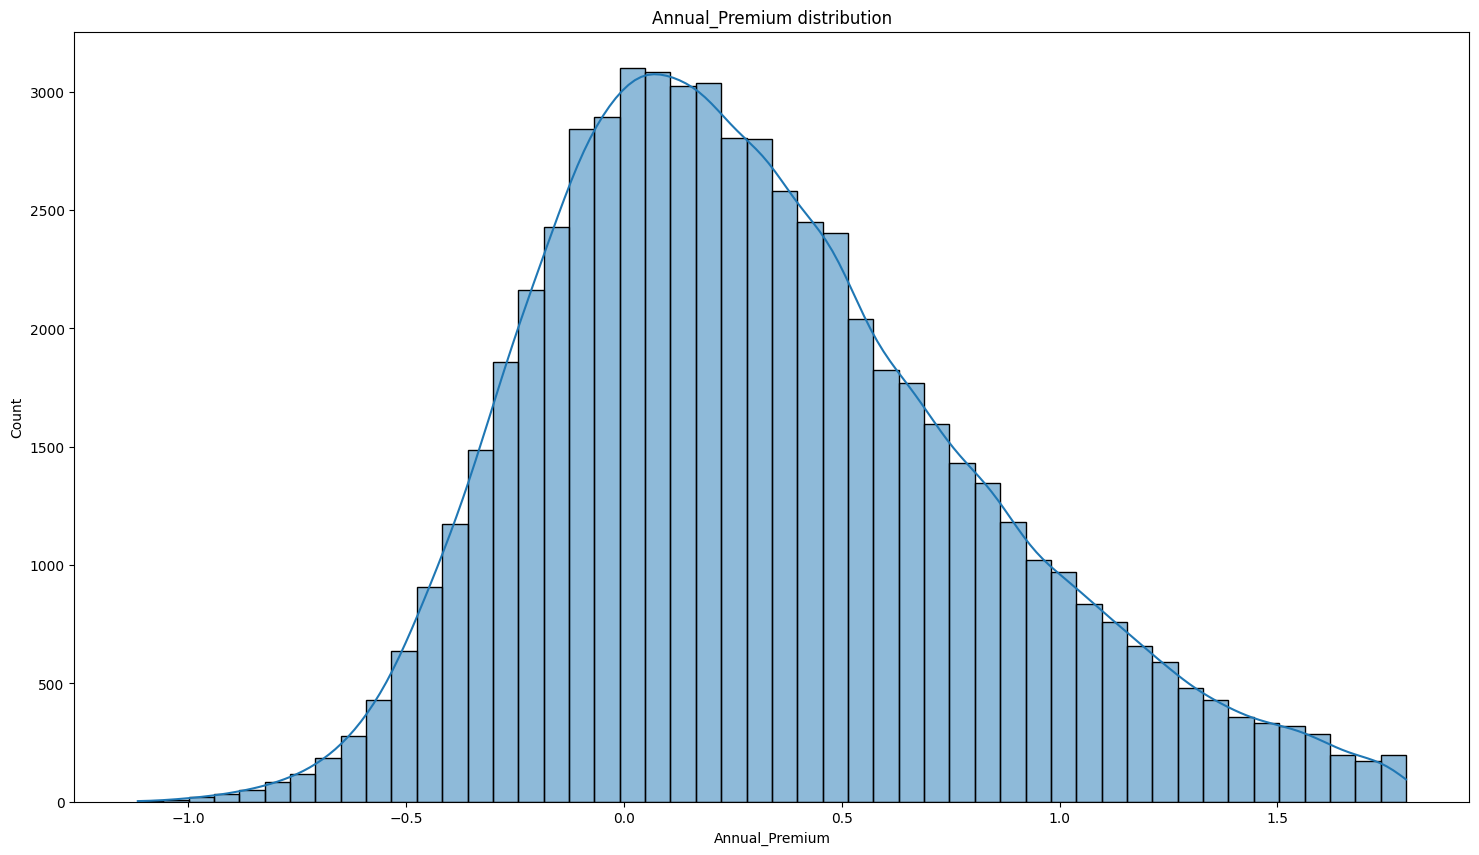

In [25]:
create_hist_plot(df_test1, 'Annual_Premium')

In [26]:
gen_info_feat(df_train1,'Annual_Premium')

Description:
count   246383.000000
mean         0.312680
std          0.496855
min         -1.500080
25%         -0.047462
50%          0.250235
75%          0.618805
max          1.804311
Name: Annual_Premium, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
0.5241991571088146
**************************************************
kurtosis:
-0.01949545100121375
**************************************************



In [27]:
# descriptive statics for numerical attributes

num_cols = ['Annual_Premium','Policy_Sales_Channel', 'Vintage','Age']


data_statistics = df_train1[num_cols].describe().reset_index()
skew = pd.DataFrame(df_train1[num_cols].apply(lambda x: x.skew())).T
data_statistics = pd.concat([data_statistics, skew]).fillna('Skew')
kurtosis = pd.DataFrame(df_train1[num_cols].apply(lambda x: x.kurtosis())).T
data_statistics = pd.concat([data_statistics, kurtosis]).fillna('Kurtosis')
data_statistics.set_index('index')
data_statistics

,index,Annual_Premium,Policy_Sales_Channel,Vintage,Age
0,count,246383.000000,246383.000000,246383.000000,246383.000000
1,mean,0.312680,0.224465,154.291006,38.243527
2,std,0.496855,0.123081,83.705054,15.534114
3,min,-1.500080,0.000026,10.000000,20.000000
4,25%,-0.047462,0.193963,82.000000,24.000000
5,50%,0.250235,0.209346,154.000000,35.000000
6,75%,0.618805,0.353728,227.000000,49.000000
7,max,1.804311,0.353728,299.000000,85.000000
0,Skew,0.524199,-0.482831,0.004188,0.723396
0,Kurtosis,-0.019495,-0.951010,-1.200304,-0.515260


### Inference
- we will use modern version of box cox to transform annual premium

In [28]:
df_train1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
235830,1,56,1,0.018226,0,1,0.231968,0.193963,46,0,0,1
59581,0,74,1,0.279714,1,0,1.111589,0.193963,159,0,0,0
230275,1,46,1,0.088761,0,1,0.263389,0.193963,214,0,0,0
145514,1,21,1,0.014754,0,1,-0.389599,0.056914,98,0,1,0
123031,0,36,1,0.279714,0,1,0.476967,0.193963,258,0,0,0


In [29]:
# applying standard scaler to numerical features

# Columns to standardize
std_cols = ['Age', 'Annual_Premium', 'Vintage']

# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data and transform
df_train1[std_cols] = scaler.fit_transform(df_train1[std_cols])

df_test1[std_cols] = scaler.transform(df_test1[std_cols])

In [30]:
joblib.dump(scaler, 'numerical_standard_scaler.pkl')

['numerical_standard_scaler.pkl']

In [31]:
# applying min max scaler to frequency encoded features just to be on the safer side

std_cols = ['Region_Code','Policy_Sales_Channel']

# Initialize scaler
minmax = MinMaxScaler()

# Fit ONLY on training data and transform
df_train1[std_cols] = minmax.fit_transform(df_train1[std_cols])

df_test1[std_cols] = minmax.transform(df_test1[std_cols])

In [32]:
joblib.dump(scaler, 'num_columns_maxmin_scaler.pkl')

['num_columns_maxmin_scaler.pkl']

In [33]:
df_train1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
235830,1,1.143065,1,0.063490,0,1,-0.162446,0.548305,-1.293724,0,0,1
59581,0,2.301808,1,1.000000,1,0,1.607934,0.548305,0.056257,0,0,0
230275,1,0.499320,1,0.316108,0,1,-0.099206,0.548305,0.713327,0,0,0
145514,1,-1.110045,1,0.051053,0,1,-1.413451,0.160834,-0.672494,0,1,0
123031,0,-0.144426,1,1.000000,0,1,0.330654,0.548305,1.238984,0,0,0


In [34]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246383 entries, 235830 to 119727
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 246383 non-null  int32  
 1   Age                    246383 non-null  float64
 2   Driving_License        246383 non-null  int64  
 3   Region_Code            246383 non-null  float64
 4   Previously_Insured     246383 non-null  int64  
 5   Vehicle_Damage         246383 non-null  int32  
 6   Annual_Premium         246383 non-null  float64
 7   Policy_Sales_Channel   246383 non-null  float64
 8   Vintage                246383 non-null  float64
 9   Response               246383 non-null  int64  
 10  Vehicle_Age_< 1 Year   246383 non-null  int32  
 11  Vehicle_Age_> 2 Years  246383 non-null  int32  
dtypes: float64(5), int32(4), int64(3)
memory usage: 20.7 MB


In [35]:
# calculate vif

def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)  # skip constant at index 0
        for i in range(len(numeric_df.columns))
    ]

    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

In [36]:
X = df_train1.drop(columns='Response')

In [37]:
vif_table = calculate_vif(X, target_col='Response')
print(vif_table)

                  feature      VIF
0    Vehicle_Age_< 1 Year 3.567543
1          Vehicle_Damage 3.526181
2      Previously_Insured 3.481877
3                     Age 2.971635
4    Policy_Sales_Channel 1.485093
5             Region_Code 1.335274
6          Annual_Premium 1.183715
7   Vehicle_Age_> 2 Years 1.090315
8                  Gender 1.033519
9         Driving_License 1.008248
10                Vintage 1.000056


inference:
- general rule of vif:
    * VIF = 1: No correlation.
    * VIF 1 to 5: Moderate correlation (usually acceptable).
    * VIF > 5 to 10: High correlation (may be problematic).
    * VIF > 10: Severe multicollinearity. The variables are redundant and will likely make your model coefficients unstable.

Based on the above information, we dont need to remove any features

In [38]:
df_train1.columns = (
    df_train1.columns
    .str.replace('<', 'less_', regex=False)
    .str.replace('>', 'greater_', regex=False)
    .str.replace(' ', '_')
)

df_test1.columns = (
    df_test1.columns
    .str.replace('<', 'less_', regex=False)
    .str.replace('>', 'greater_', regex=False)
    .str.replace(' ', '_')
)

In [39]:
df_train1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_less__1_Year,Vehicle_Age_greater__2_Years
235830,1,1.143065,1,0.063490,0,1,-0.162446,0.548305,-1.293724,0,0,1
59581,0,2.301808,1,1.000000,1,0,1.607934,0.548305,0.056257,0,0,0
230275,1,0.499320,1,0.316108,0,1,-0.099206,0.548305,0.713327,0,0,0
145514,1,-1.110045,1,0.051053,0,1,-1.413451,0.160834,-0.672494,0,1,0
123031,0,-0.144426,1,1.000000,0,1,0.330654,0.548305,1.238984,0,0,0


In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

In [41]:
## we are using smotetomek and checking another kind of dataset
df_train2 = df_train1.copy()

X = df_train2.drop(columns=['Response'])
y = df_train2['Response']

smt = SMOTETomek(sampling_strategy=0.40, random_state=42)

X_res, y_res = smt.fit_resample(X, y)

# Recombine into dataframe (back to original clean format)
df_train2_resampled = pd.concat(
    [pd.DataFrame(X_res, columns=X.columns),
     pd.Series(y_res, name='Response')],
    axis=1
)

In [42]:
## we are using smotetomek and checking another kind of dataset
df_train3 = df_train1.copy()

X = df_train3.drop(columns=['Response'])
y = df_train3['Response']

smt = SMOTEENN(sampling_strategy=0.40, random_state=42)

X_res, y_res = smt.fit_resample(X, y)

# Recombine into dataframe (back to original clean format)
df_train3_resampled = pd.concat(
    [pd.DataFrame(X_res, columns=X.columns),
     pd.Series(y_res, name='Response')],
    axis=1
)

In [43]:
## we are using smotetomek and checking another kind of dataset
df_train4 = df_train1.copy()

X = df_train4.drop(columns=['Response'])
y = df_train4['Response']

smt = SMOTE(sampling_strategy=0.40, random_state=42)

X_res, y_res = smt.fit_resample(X, y)

# Recombine into dataframe (back to original clean format)
df_train4_resampled = pd.concat(
    [pd.DataFrame(X_res, columns=X.columns),
     pd.Series(y_res, name='Response')],
    axis=1
)

#### Checking for linearity 

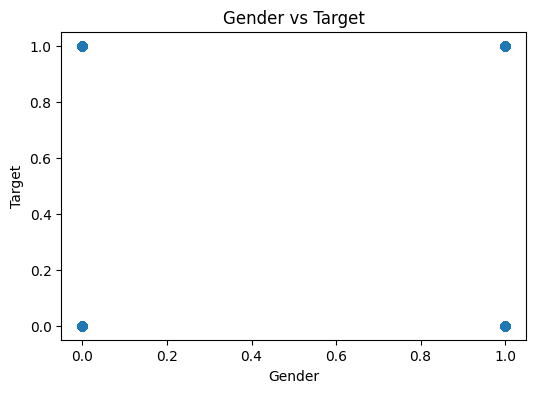

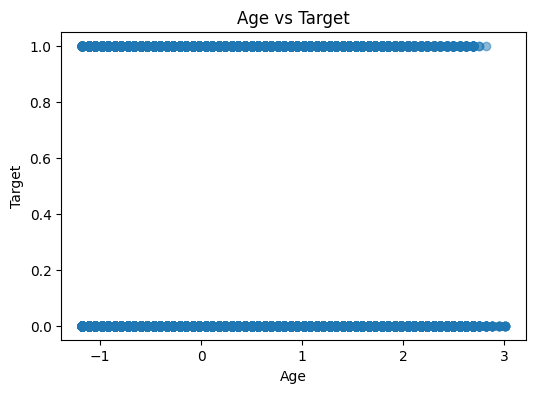

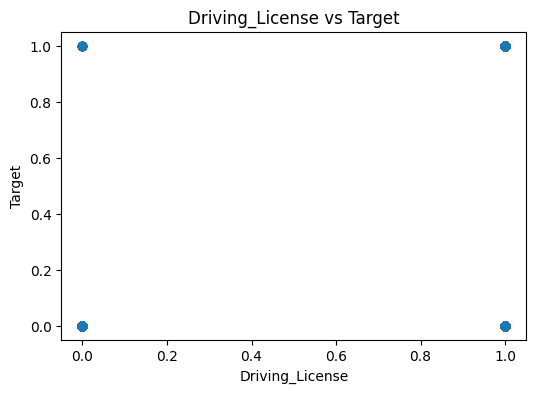

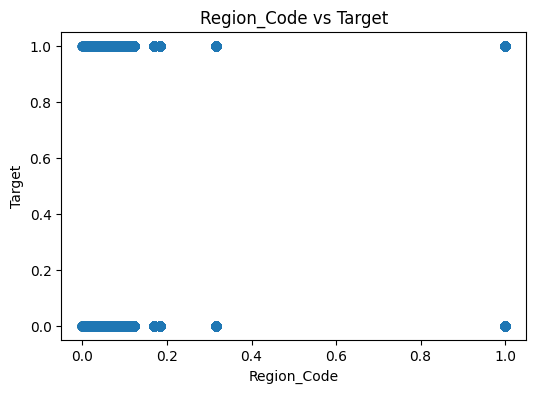

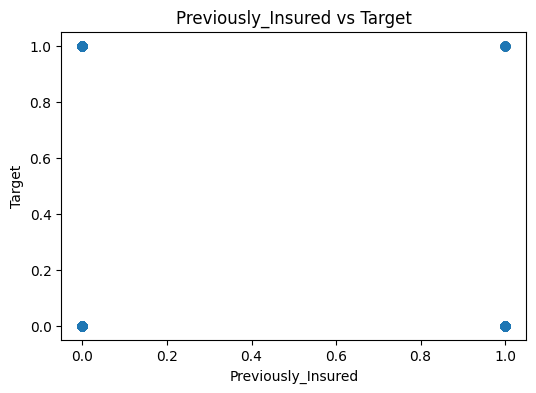

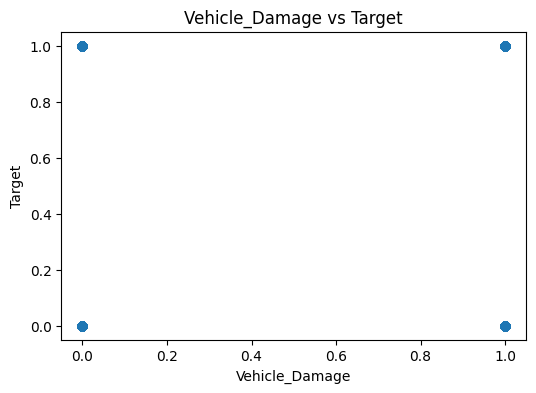

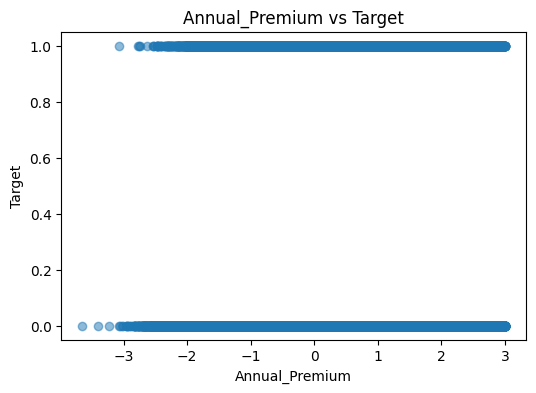

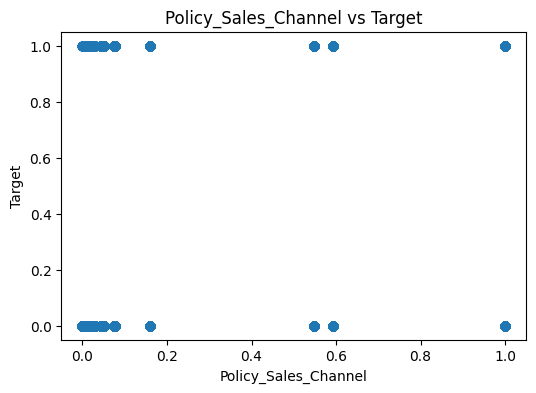

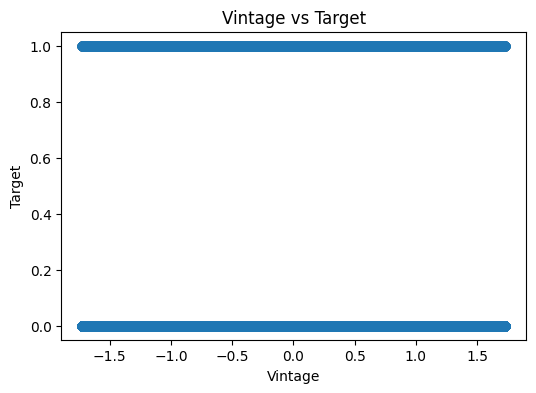

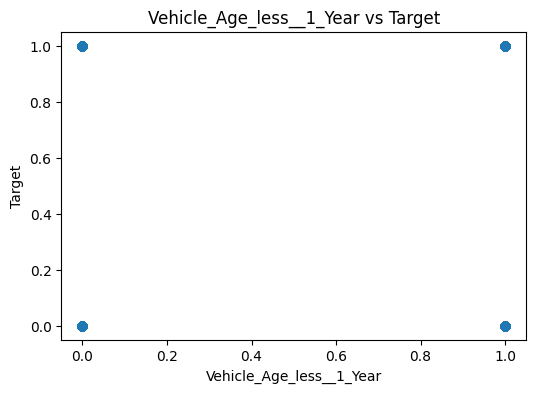

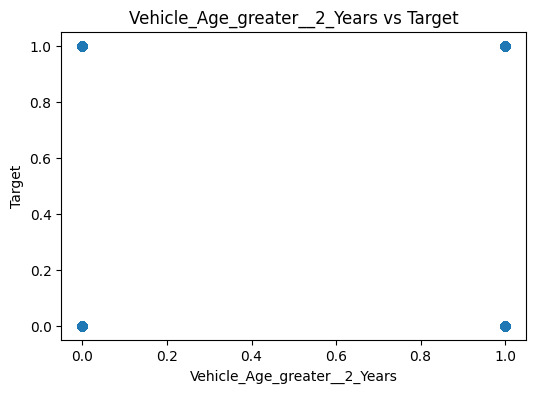

In [44]:
# Feature vs Target (linearity check)
for col in X.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(X[col], y, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Target")
    plt.title(f"{col} vs Target")
    plt.show()

In [45]:
df_train1.corr()['Response'].sort_values(ascending=False)

Response                        1.000000
Vehicle_Damage                  0.365773
Region_Code                     0.132932
Age                             0.124509
Vehicle_Age_greater__2_Years    0.116975
Annual_Premium                  0.058376
Gender                          0.055714
Driving_License                 0.009907
Vintage                        -0.000563
Policy_Sales_Channel           -0.156867
Vehicle_Age_less__1_Year       -0.223119
Previously_Insured             -0.351785
Name: Response, dtype: float64

## Model Selection Inference from EDA

To decide which machine learning algorithms are likely to perform well before training models, we analyzed:

- Feature vs Target scatter plots  
- Correlation of each feature with the target variable (`Response`)  

---

### Feature vs Target Scatter Plot Observations

The scatter plots of continuous and encoded categorical features against the binary target (`Response`) showed:

- Heavy overlap between classes (0 and 1) across almost all feature values  
- No clear monotonic or linear separation between features and the target  
- Both classes appearing across the full range of important variables such as `Age`, `Region_Code`, and `Driving_License`  

#### Interpretation:

This indicates that:

- Individual features do not have strong linear relationships with the target  
- Predictive signal likely exists in **interactions between multiple features** rather than in single variables  

Such patterns are difficult for linear models to capture without extensive manual feature engineering.

---

### Correlation Analysis with Target

Correlation values with `Response`:

| Feature | Correlation |
|--------|-------------|
| Vehicle_Damage | 0.366 |
| Previously_Insured | -0.352 |
| Region_Code | 0.133 |
| Age | 0.125 |
| Vehicle_Age_>2_Years | 0.117 |
| Annual_Premium | 0.058 |
| Gender | 0.056 |
| Driving_License | 0.010 |
| Vintage | ~0 |
| Policy_Sales_Channel | -0.157 |
| Vehicle_Age_<1_Year | -0.223 |

#### Interpretation:

- Only two features show moderate linear correlation with the target  
- Most features have weak or near-zero correlation  
- No group of strongly linearly predictive variables exists  

This pattern suggests that:

> The target is not well explained by linear combinations of individual features.

Instead, the model must combine multiple weak signals to form accurate predictions.

---

### Justification for Tree-Based Models

Tree-based models:

- Automatically capture feature interactions  
- Handle nonlinear decision boundaries effectively  
- Combine weak predictors into strong decision rules  
- Are robust to skewed distributions and mixed feature types  


### Why Linear Models Are Likely Suboptimal

Linear/Logistic Regression assumes:

- Additive effects of features  
- Linear relationship between predictors and target  

However, EDA shows:

- Weak individual correlations  
- Strong overlap between classes  
- Interaction-driven signal  

Therefore:

- Linear models will mostly rely on a few moderate predictors  
- They will fail to capture complex structure present in the data  

---

## Final Conclusion

Based on:

- Lack of strong linear separability in scatter plots  
- Predominantly weak feature-target correlations  
- Evidence of interaction-driven predictive patterns  

**Tree-based ensemble models are the most appropriate choice for this dataset**, while linear models should be used only as simple baselines.


In [46]:
df_train1['Response'].value_counts()/df_train1.shape[0]

Response
0   0.879996
1   0.120004
Name: count, dtype: float64

In [47]:
df_train2_resampled['Response'].value_counts()/df_train2_resampled.shape[0]

Response
0   0.722144
1   0.277856
Name: count, dtype: float64

In [48]:
df_train3_resampled['Response'].value_counts()/df_train3_resampled.shape[0]

Response
0   0.760317
1   0.239683
Name: count, dtype: float64

In [49]:
# Saving the datasets

import os

# Base project directory (one level up from notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Data folder path
DATA_DIR = os.path.join(BASE_DIR, "data")

# Make sure folder exists
os.makedirs(DATA_DIR, exist_ok=True)

# Save files
df_train2_resampled.to_csv(os.path.join(DATA_DIR, "df_train.csv"), index=False)
df_test1.to_csv(os.path.join(DATA_DIR, "df_test.csv"), index=False)

print("Files saved to:", DATA_DIR)

Files saved to: c:\Users\user\Desktop\BIA Insurance Prediction Project\data


In [50]:
# Saving the datasets

import os

# Base project directory (one level up from notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Data folder path
DATA_DIR = os.path.join(BASE_DIR, "data")

# Make sure folder exists
os.makedirs(DATA_DIR, exist_ok=True)

# Save files
df_train3_resampled.to_csv(os.path.join(DATA_DIR, "df_train1.csv"), index=False)

print("Files saved to:", DATA_DIR)

Files saved to: c:\Users\user\Desktop\BIA Insurance Prediction Project\data


In [51]:
import os

# Base project directory (one level up from notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Data folder path
DATA_DIR = os.path.join(BASE_DIR, "data")

# Make sure folder exists
os.makedirs(DATA_DIR, exist_ok=True)

# Save files
df_train4_resampled.to_csv(os.path.join(DATA_DIR, "df_train2.csv"), index=False)

print("Files saved to:", DATA_DIR)

Files saved to: c:\Users\user\Desktop\BIA Insurance Prediction Project\data


In [52]:
import os

# Base project directory (one level up from notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Data folder path
DATA_DIR = os.path.join(BASE_DIR, "data")

# Make sure folder exists
os.makedirs(DATA_DIR, exist_ok=True)

# Save files
df_train1.to_csv(os.path.join(DATA_DIR, "df_train_original.csv"), index=False)

print("Files saved to:", DATA_DIR)

Files saved to: c:\Users\user\Desktop\BIA Insurance Prediction Project\data
